1) **Environment & imports**

Install / import packages, set DEVICE (CPU / CUDA), print device.

2) **Load dataset**

Load EllipticBitcoinDataset(root='./dataset'), take data = dataset[0].to(DEVICE).

Ensure data.edge_index dtype correct.

3) **Label mask and preprocessing**

Create mask = data.y != -1 and labels = data.y.clone(); extract labeled indices mask_idx.

In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import EllipticBitcoinDataset
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split

# Set device
DEVICE = torch.device('cpu')  # Use 'cuda' if GPU is available
print(f'Using device: {DEVICE}')

# Load the dataset
dataset = EllipticBitcoinDataset(root='./dataset')
data = dataset[0].to(DEVICE)
print(data)

# Ensure edge_index is long type
data.edge_index = data.edge_index.to(torch.long)

# Prepare labels mask (exclude unlabeled nodes)
mask = data.y != -1
labels = data.y.clone()

d:\DL Project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu
Data(x=[203769, 165], edge_index=[2, 234355], y=[203769], train_mask=[203769], test_mask=[203769])


4) **Initial stratified splits (3-class pipeline)**

Stratified train/test split on mask_idx (test_size=0.3) then split test → val + test (50/50).

Convert indices to torch tensors on DEVICE. Print sizes.

In [2]:
# Extract indices of labeled nodes
mask_idx = mask.nonzero(as_tuple=True)[0]

# Stratified train/test split
train_idx, test_idx = train_test_split(
    mask_idx.cpu(),
    test_size=0.3,
    stratify=labels[mask].cpu(),
    random_state=42
)

# Split test into validation and test
val_idx, test_idx = train_test_split(
    test_idx,
    test_size=0.5,
    stratify=labels[test_idx].cpu(),
    random_state=42
)

# Convert indices to torch tensors on DEVICE
train_idx = torch.tensor(train_idx, dtype=torch.long, device=DEVICE)
val_idx = torch.tensor(val_idx, dtype=torch.long, device=DEVICE)
test_idx = torch.tensor(test_idx, dtype=torch.long, device=DEVICE)

print(f"Train size: {train_idx.size(0)}, Val size: {val_idx.size(0)}, Test size: {test_idx.size(0)}")


Train size: 142638, Val size: 30565, Test size: 30566


C:\Users\Varun\AppData\Local\Temp\ipykernel_2752\3896827760.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_idx = torch.tensor(train_idx, dtype=torch.long, device=DEVICE)
C:\Users\Varun\AppData\Local\Temp\ipykernel_2752\3896827760.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_idx = torch.tensor(val_idx, dtype=torch.long, device=DEVICE)
C:\Users\Varun\AppData\Local\Temp\ipykernel_2752\3896827760.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_idx = torch.tensor(test_idx, dtype=torch.long, device=DEVICE)


5) **Class weighting for imbalance (3-class)**

Compute class_counts from train_labels, compute inverse-frequency class_weights normalized, use in nn.CrossEntropyLoss(weight=class_weights).

In [3]:
# Extract training labels
train_labels = labels[train_idx]

# Count number of nodes per class
class_counts = torch.bincount(train_labels)

# Handle case where some classes might be missing in batch
if class_counts.numel() < 2:
    tmp = torch.zeros(2, dtype=class_counts.dtype, device=class_counts.device)
    tmp[:class_counts.numel()] = class_counts
    class_counts = tmp

# Compute inverse frequency weights and normalize
class_weights = 1.0 / class_counts.float()
class_weights = (class_weights / class_weights.sum()) * len(class_counts)
class_weights = class_weights.to(DEVICE)

print("Class counts:", class_counts.cpu().numpy())
print("Class weights:", class_weights.cpu().numpy())

# Define Cross-Entropy Loss with class weights
ce_loss_fn = nn.CrossEntropyLoss(weight=class_weights)


Class counts: [ 29413   3182 110043]
Class weights: [0.28541952 2.6382918  0.07628876]


6) **Model definitions**

BWGNNEncoder with three parallel GCNConv branches (low/mid/high), concat → fc_out.

BWGNNClassifier wrapping encoder + linear classifier head.

recon_loss_from_z(z, edge_index) — unsupervised reconstruction regularizer.

In [4]:
from torch_geometric.nn import GCNConv

class BWGNNEncoder(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, dropout=0.3):
        super().__init__()
        # Parallel GCN layers for band-pass (simulating Beta wavelets)
        self.gcn_low = GCNConv(in_dim, hid_dim)    # Low-pass
        self.gcn_mid = GCNConv(in_dim, hid_dim)    # Mid-band
        self.gcn_high = GCNConv(in_dim, hid_dim)   # High-pass

        self.fc_out = nn.Linear(hid_dim * 3, out_dim)  # Combine all branches
        self.dropout = dropout

    def forward(self, x, edge_index):
        # Each branch
        x_low = F.relu(self.gcn_low(x, edge_index))
        x_mid = F.relu(self.gcn_mid(x, edge_index))
        x_high = F.relu(self.gcn_high(x, edge_index))

        # Dropout
        x_low = F.dropout(x_low, p=self.dropout, training=self.training)
        x_mid = F.dropout(x_mid, p=self.dropout, training=self.training)
        x_high = F.dropout(x_high, p=self.dropout, training=self.training)

        # Concatenate features from all branches
        x_cat = torch.cat([x_low, x_mid, x_high], dim=1)
        z = self.fc_out(x_cat)  # final embedding
        return z

class BWGNNClassifier(nn.Module):
    def __init__(self, encoder, num_classes, dropout=0.3):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(encoder.fc_out.out_features, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index):
        z = self.encoder(x, edge_index)
        logits = self.classifier(F.dropout(z, p=self.dropout, training=self.training))
        return logits, z


In [5]:
def recon_loss_from_z(z, edge_index):
    """
    Simple unsupervised reconstruction loss.
    Measures similarity of connected nodes in embedding space.
    """
    row, col = edge_index
    # Dot product of embeddings for each edge
    pos_scores = (z[row] * z[col]).sum(dim=1)
    # Apply sigmoid + log for binary cross-entropy style loss
    loss = -torch.log(torch.sigmoid(pos_scores) + 1e-8).mean()
    return loss


7) **Hyperparameters (initial defaults)**

Example defaults used: hid_dim=128, emb_dim=64, lr=0.01, weight_decay=5e-4, dropout=0.3, epochs=100, lambda_recon=0.1.

In [ ]:
# Hyperparameters
in_dim = data.x.size(1)
hid_dim = 128
emb_dim = 64
num_classes = 3       # same as SAGE
lr = 0.01
weight_decay = 5e-4
dropout = 0.3
epochs = 100
lambda_recon = 0.1   # weight for reconstruction loss

# Instantiate encoder and classifier
encoder = BWGNNEncoder(in_dim, hid_dim, emb_dim, dropout=dropout).to(DEVICE)
model_bwgnn = BWGNNClassifier(encoder, num_classes, dropout=dropout).to(DEVICE)

# Optimizer
optimizer = torch.optim.Adam(model_bwgnn.parameters(), lr=lr, weight_decay=weight_decay)

print("BWGNN model instantiated and optimizer ready.")


BWGNN model instantiated and optimizer ready.


: 

8) **Train / validate (3-class)**

Instantiate encoder + model_bwgnn, optimizer, train loop: forward → loss_ce on train_idx + lambda_recon * rloss → backward → step.

Eval on val_idx at intervals → print loss and classification report.

In [ ]:
# Store metrics if needed
metrics_data = {}

for epoch in range(1, epochs + 1):
    model_bwgnn.train()
    optimizer.zero_grad()

    # Forward pass
    logits, z_all = model_bwgnn(data.x, data.edge_index)

    # Cross-entropy loss on training nodes
    loss_ce = ce_loss_fn(logits[train_idx], labels[train_idx])

    # Optional reconstruction loss
    if lambda_recon > 0:
        rloss = recon_loss_from_z(z_all, data.edge_index)
    else:
        rloss = torch.tensor(0.0, device=DEVICE)

    # Total loss
    loss = loss_ce + lambda_recon * rloss
    loss.backward()
    optimizer.step()

    # Validation metrics every 5 epochs
    if epoch % 5 == 0 or epoch == 1:
        model_bwgnn.eval()
        with torch.no_grad():
            logits_val, _ = model_bwgnn(data.x, data.edge_index)
            preds_val = logits_val[val_idx].argmax(dim=1).cpu()
            true_val = labels[val_idx].cpu()
            print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | CE: {loss_ce.item():.4f} | Recon: {rloss.item():.4f}")
            from sklearn.metrics import classification_report
            print("Validation metrics:")
            print(classification_report(
              true_val,
              preds_val,
              labels=[0,1,2],  # list all possible class labels
              target_names=['licit(0)','illicit(1)','unknown(2)'],
              zero_division=0
            ))



Epoch 001 | Loss: 1.1723 | CE: 1.1618 | Recon: 0.1049
Validation metrics:
              precision    recall  f1-score   support

    licit(0)       0.21      1.00      0.34      6303
  illicit(1)       0.00      0.00      0.00       681
  unknown(2)       0.00      0.00      0.00     23581

    accuracy                           0.21     30565
   macro avg       0.07      0.33      0.11     30565
weighted avg       0.04      0.21      0.07     30565



9) **Evaluation & metrics collection (3-class)**

Use evaluate_model(...) to compute precision/recall/f1/accuracy and per-class reports on splits. Store in metrics_data.

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
import torch.nn.functional as F

# Evaluation function for BWGNN (similar to SAGE)
def evaluate_model(model, data, test_idx, labels, name, metrics_store):
    model.eval()
    with torch.no_grad():
        logits, _ = model(data.x, data.edge_index)
        preds = logits.argmax(dim=1)[test_idx].cpu()
        y_true = labels[test_idx].cpu()

    precision = precision_score(y_true, preds, average='macro', zero_division=0)
    recall = recall_score(y_true, preds, average='macro', zero_division=0)
    f1 = f1_score(y_true, preds, average='macro', zero_division=0)
    acc = accuracy_score(y_true, preds)
    report = classification_report(y_true, preds, output_dict=True, zero_division=0)

    metrics_store[name] = {
        "precision": round(precision, 4),
        "recall": round(recall, 4),
        "f1": round(f1, 4),
        "accuracy": round(acc, 4),
        "per_class_report": report
    }

    print(f"✅ {name} Model Results:")
    print(f"  Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | Accuracy: {acc:.4f}\n")
    return preds

In [ ]:
evaluate_model(model_bwgnn, data, test_idx, labels, "BWGNN", metrics_data)

✅ BWGNN Model Results:
  Precision: 0.5390 | Recall: 0.6670 | F1: 0.5653 | Accuracy: 0.7585



tensor([2, 2, 2,  ..., 2, 2, 2])

10) **Known-only pipeline (2-class)**

Create known_mask = (labels==0)|(labels==1) and unknown_idx = (labels==2); derive known_idx.

Stratified train/val split on known_idx. Recompute class weights for two-class case.

Instantiate separate encoder + model_bwgnn_known with num_classes=2 and train/eval similarly.

In [ ]:
# Known nodes mask: classes 0 and 1
known_mask = (labels == 0) | (labels == 1)
known_idx = known_mask.nonzero(as_tuple=True)[0]
unknown_idx = (labels == 2).nonzero(as_tuple=True)[0]

# Train/Val split for known nodes
train_idx, val_idx = train_test_split(
    known_idx.cpu().numpy(),
    test_size=0.2,
    stratify=labels[known_idx].cpu().numpy(),
    random_state=42
)
train_idx = torch.tensor(train_idx, dtype=torch.long, device=DEVICE)
val_idx = torch.tensor(val_idx, dtype=torch.long, device=DEVICE)
test_unknown_idx = unknown_idx.to(DEVICE)

In [ ]:
# compute class weights from training labels (only known classes)
train_labels = labels[train_idx]
class_counts = torch.bincount(train_labels)
# handle if some class missing in batch (rare)
if class_counts.numel() < 2:
    # ensure 2 classes exist
    tmp = torch.zeros(2, dtype=class_counts.dtype, device=class_counts.device)
    tmp[:class_counts.numel()] = class_counts
    class_counts = tmp
class_weights = 1.0 / class_counts.float()
class_weights = (class_weights / class_weights.sum()) * len(class_counts)
class_weights = class_weights.to(DEVICE)
print("Class counts:", class_counts.cpu().numpy(), "Class weights:", class_weights.cpu().numpy())

ce_loss_fn = nn.CrossEntropyLoss(weight=class_weights)

Class counts: [33615  3636] Class weights: [0.19521624 1.8047837 ]


In [ ]:
num_classes = 2  # only known classes: licit(0), illicit(1)
encoder = BWGNNEncoder(in_dim, hid_dim, emb_dim, dropout=dropout).to(DEVICE)
model_bwgnn_known = BWGNNClassifier(encoder, num_classes, dropout=dropout).to(DEVICE)
optimizer = torch.optim.Adam(model_bwgnn_known.parameters(), lr=lr, weight_decay=weight_decay)

In [ ]:
epochs = 100

for epoch in range(1, epochs + 1):
    model_bwgnn_known.train()
    optimizer.zero_grad()
    logits, z_all = model_bwgnn_known(data.x, data.edge_index)           # logits: [N, num_classes]
    # select only train nodes (labels 0 or 1)
    loss_ce = ce_loss_fn(logits[train_idx], labels[train_idx])
    # optional recon:
    if lambda_recon > 0:
        rloss = recon_loss_from_z(z_all, data.edge_index)
    else:
        rloss = torch.tensor(0.0, device=DEVICE)
    loss = loss_ce + lambda_recon * rloss
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0 or epoch == 1:
        model_bwgnn_known.eval()
        with torch.no_grad():
            logits_eval, _ = model_bwgnn_known(data.x, data.edge_index)
            preds_val = logits_eval[val_idx].argmax(dim=1).cpu()
            true_val = labels[val_idx].cpu()
            print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | CE: {loss_ce.item():.4f} | Recon: {rloss.item():.4f}")
            print("Val known metrics:")
            print(classification_report(true_val, preds_val, target_names=['licit(0)','illicit(1)'], zero_division=0))


Epoch 001 | Loss: 0.7418 | CE: 0.7348 | Recon: 0.0702
Val known metrics:
              precision    recall  f1-score   support

    licit(0)       0.90      1.00      0.95      8404
  illicit(1)       0.00      0.00      0.00       909

    accuracy                           0.90      9313
   macro avg       0.45      0.50      0.47      9313
weighted avg       0.81      0.90      0.86      9313

Epoch 005 | Loss: 0.5462 | CE: 0.5446 | Recon: 0.0165
Val known metrics:
              precision    recall  f1-score   support

    licit(0)       1.00      0.44      0.61      8404
  illicit(1)       0.16      0.99      0.28       909

    accuracy                           0.50      9313
   macro avg       0.58      0.72      0.45      9313
weighted avg       0.92      0.50      0.58      9313

Epoch 010 | Loss: 0.4778 | CE: 0.4759 | Recon: 0.0191
Val known metrics:
              precision    recall  f1-score   support

    licit(0)       0.97      0.87      0.92      8404
  illicit(1)      

In [ ]:
# Evaluate BWGNN on known test nodes
evaluate_model(model_bwgnn_known, data, val_idx, labels, "BWGNN-known", metrics_data)

✅ BWGNN-known Model Results:
  Precision: 0.6800 | Recall: 0.8403 | F1: 0.7173 | Accuracy: 0.8525



tensor([1, 0, 1,  ..., 0, 0, 0])

11) **Unknown-node inference & ranking**

Use trained 3-class model (or ensemble) to compute softmax probs; for unknown nodes, extract probability for illicit class (1), rank top-K suspicious unknown nodes and print indices.

In [ ]:
# Predict probabilities for unknown nodes (class 2)
model_bwgnn.eval()
with torch.no_grad():
    logits_all, _ = model_bwgnn(data.x, data.edge_index)
    probs = F.softmax(logits_all, dim=1)
    # For unknown nodes, probability of illicit class (1)
    illicit_probs_unknown = probs[test_unknown_idx, 1].cpu()
    # Rank top-K suspicious nodes
    topk = 100
    if illicit_probs_unknown.numel() > topk:
        topk_vals, topk_idx_local = torch.topk(illicit_probs_unknown, topk)
    else:
        topk_vals = illicit_probs_unknown
        topk_idx_local = torch.arange(illicit_probs_unknown.size(0))
    topk_node_indices = test_unknown_idx[topk_idx_local]
    print(f"Top-{topk} suspicious unknown nodes (example indices): {topk_node_indices[:20].cpu().numpy()}")


Top-100 suspicious unknown nodes (example indices): [126460 116693 114916 126197  64509  58142 151074 150904 150603 151256
 151373  58112 151366 151323 149122 192696 192845 192555 192517 191147]


12) **Plots & visualizations**

Generate comparison bar plots for macro metrics, per-class metrics stored in metrics_data.

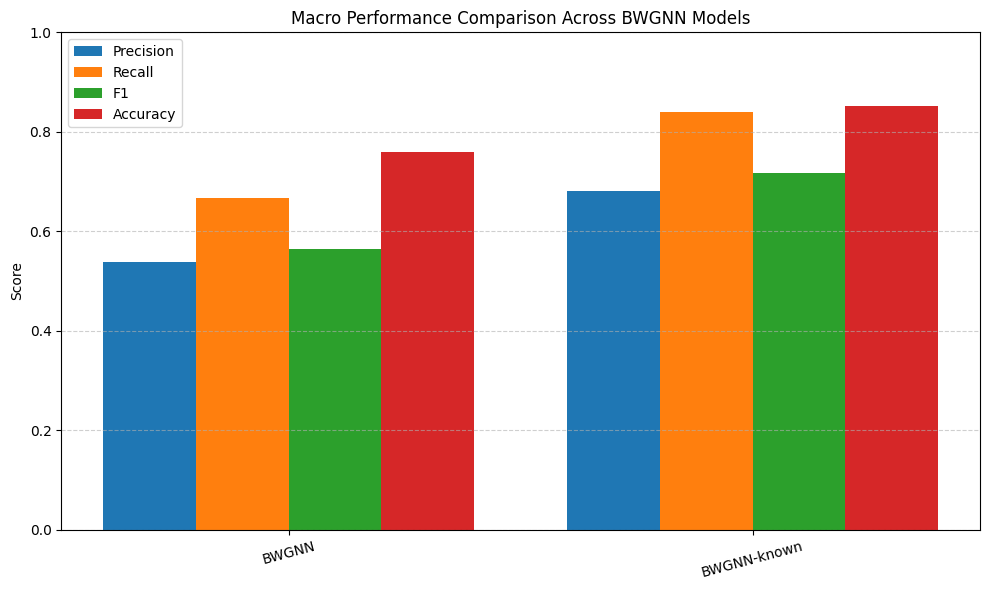

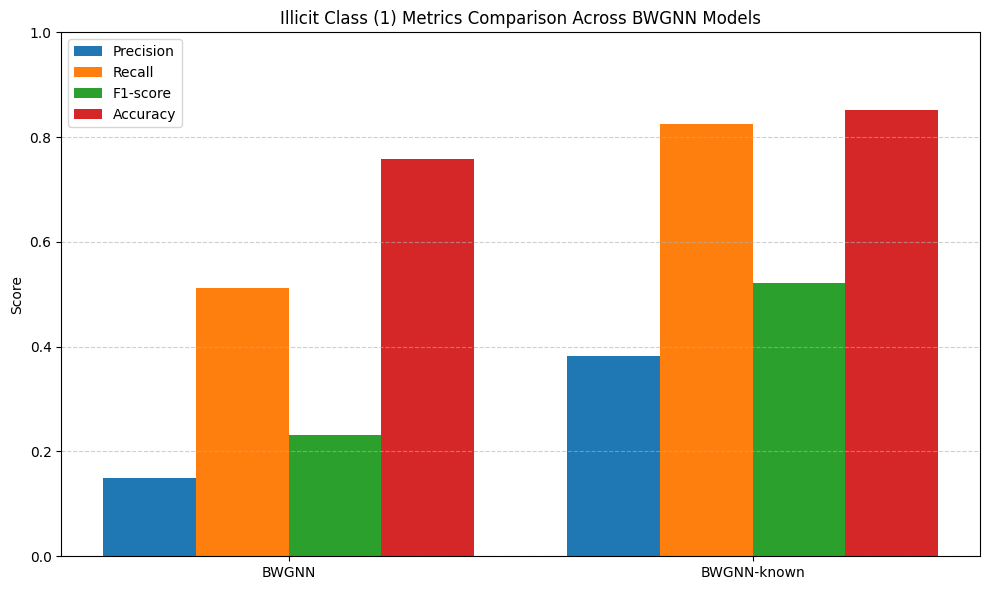

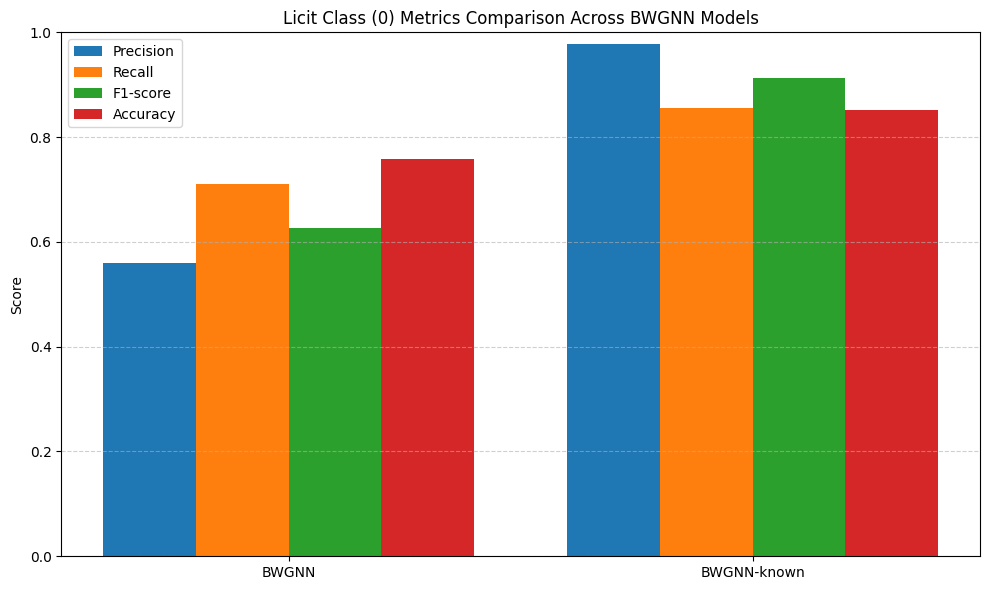

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Macro metrics
macro_metrics = ["precision", "recall", "f1", "accuracy"]
models = list(metrics_data.keys())

# Grouped bar plot for macro metrics
x = np.arange(len(models))
width = 0.2

plt.figure(figsize=(10,6))
for i, metric in enumerate(macro_metrics):
    values = [metrics_data[m][metric] for m in models]
    plt.bar(x + i*width - width*1.5, values, width, label=metric.capitalize())

plt.xticks(x, models, rotation=15)
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("Macro Performance Comparison Across BWGNN Models")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Metrics per class (0 and 1)
metrics_to_plot = ["precision", "recall", "f1-score", "accuracy"]
values_dict = {metric: [] for metric in metrics_to_plot}

for model in models:
    report = metrics_data[model]["per_class_report"]
    # Class 1 metrics
    for metric in ["precision", "recall", "f1-score"]:
        values_dict[metric].append(report.get("1", {}).get(metric, 0.0))
    # Overall accuracy
    values_dict["accuracy"].append(metrics_data[model].get("accuracy", 0.0))

# Plot Illicit class (1)
x = np.arange(len(models))
bar_width = 0.2
plt.figure(figsize=(10,6))
for i, metric in enumerate(metrics_to_plot):
    plt.bar(x + i*bar_width - bar_width*1.5, values_dict[metric], width=bar_width, label=metric.capitalize())

plt.xticks(x, models)
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("Illicit Class (1) Metrics Comparison Across BWGNN Models")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Plot Licit class (0)
values_dict = {metric: [] for metric in metrics_to_plot}
for model in models:
    report = metrics_data[model]["per_class_report"]
    for metric in ["precision", "recall", "f1-score"]:
        values_dict[metric].append(report.get("0", {}).get(metric, 0.0))
    values_dict["accuracy"].append(metrics_data[model].get("accuracy", 0.0))

x = np.arange(len(models))
plt.figure(figsize=(10,6))
for i, metric in enumerate(metrics_to_plot):
    plt.bar(x + i*bar_width - bar_width*1.5, values_dict[metric], width=bar_width, label=metric.capitalize())

plt.xticks(x, models)
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("Licit Class (0) Metrics Comparison Across BWGNN Models")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


13) **Hyperparameter Tuning Step**

In this step, we perform a full grid search over learning rate, weight decay, and dropout for both pipelines: BWGNN (3-class) and BWGNN-known (2-class).
For every combination of hyperparameters, we train a fresh model, evaluate macro-metrics, and store the results.
Then we aggregate metrics per hyperparameter to understand their effect and generate bar-plot visualizations for both pipelines.
This helps identify the best hyperparameter settings before final training.

Grid search (num_classes=2): 100%|██████████| 27/27 [05:55<00:00, 13.15s/it]


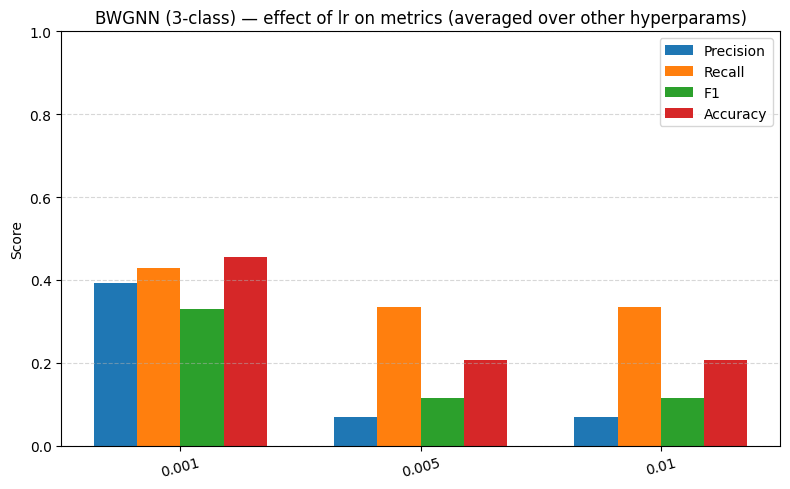

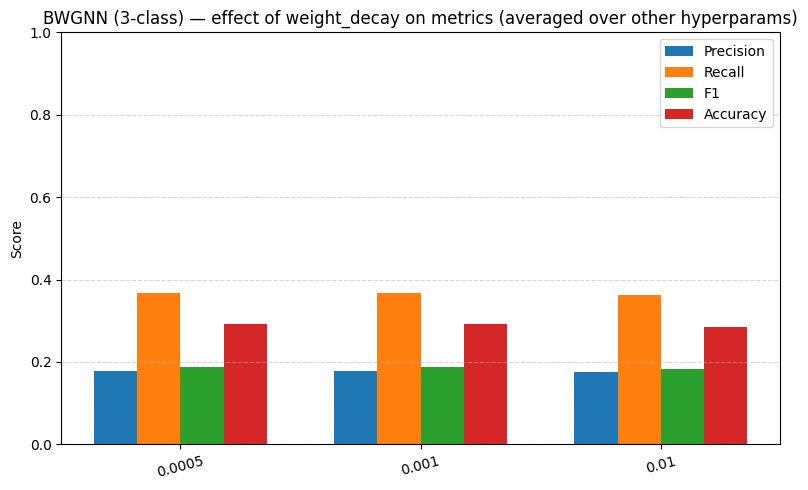

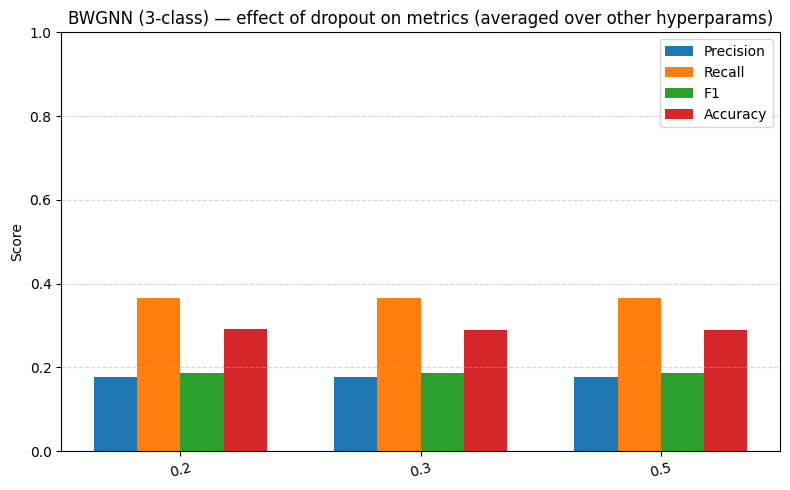

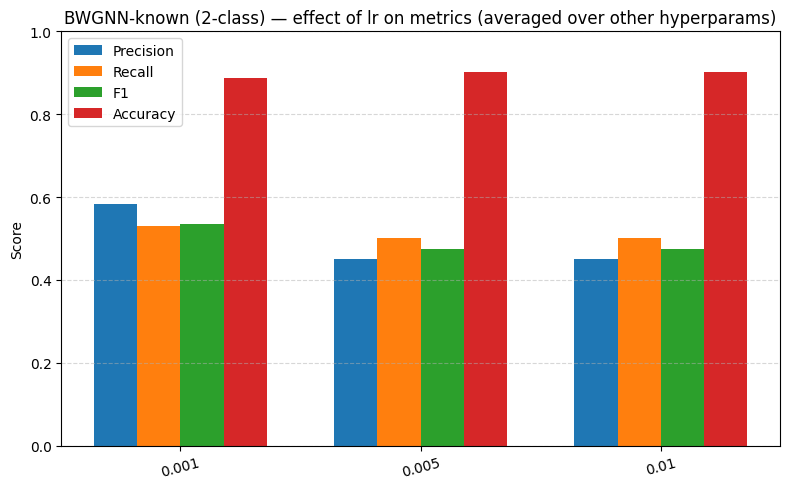

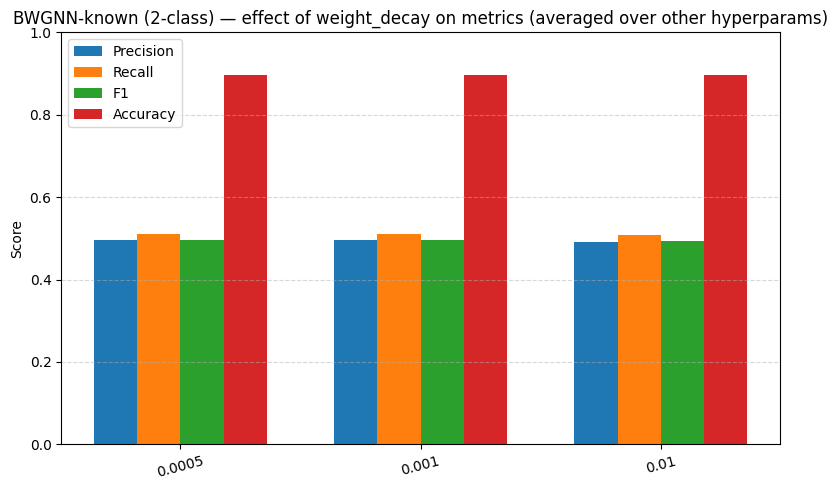

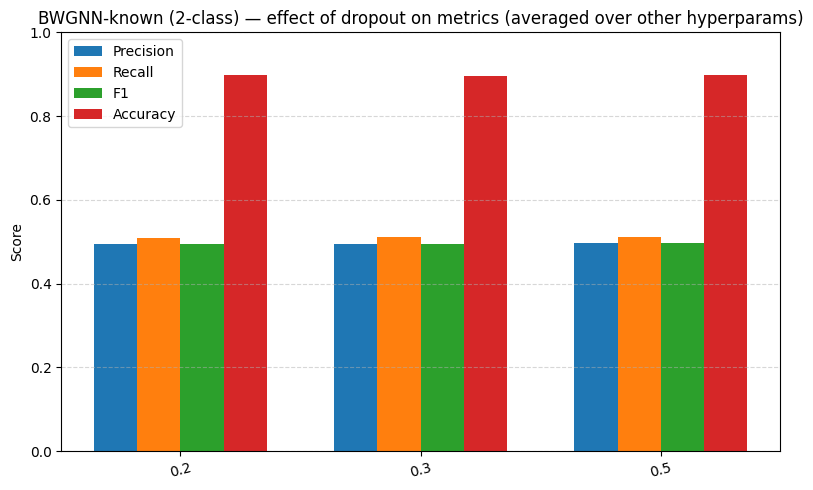

In [ ]:
# Hyperparameter tuning + plotting block for BWGNN (3-class) and BWGNN-known (2-class)
# Assumes your classes/functions (BWGNNEncoder, BWGNNClassifier, recon_loss_from_z),
# data, labels and DEVICE exist in the environment as in your provided notebook.

import itertools
import copy
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# ----- Hyperparameter grid -----
lr_list = [0.001, 0.005, 0.01]
weight_decay_list = [5e-4, 1e-3, 1e-2]
dropout_list = [0.2, 0.3, 0.5]

# Other training settings (you can tweak)
epochs_tune = 1
hid_dim = 128
emb_dim = 64
lambda_recon = 0.1
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

# Utility: training + evaluation for a single setting
def train_and_eval_pipeline(num_classes, lr, weight_decay, dropout, epochs=epochs_tune, seed=None):
    """
    Trains a BWGNN (either 3-class or 2-class pipeline) and returns macro metrics on the held-out test set.
    Splits are created inside to be self-contained and reproducible.
    """
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    # Prepare indices depending on pipeline
    if num_classes == 3:
        # use labeled nodes (y != -1) and stratified splits into train/val/test (70/15/15 approx)
        labeled_mask = (labels != -1)
        labeled_idx = labeled_mask.nonzero(as_tuple=True)[0].cpu().numpy()
        labeled_labels = labels[labeled_idx].cpu().numpy()

        train_idx_a, test_idx_a = train_test_split(
            labeled_idx, test_size=0.3, stratify=labeled_labels, random_state=seed
        )
        val_idx_a, test_idx_a = train_test_split(
            test_idx_a, test_size=0.5, stratify=labels[test_idx_a].cpu().numpy(), random_state=seed
        )
        train_idx = torch.tensor(train_idx_a, dtype=torch.long, device=DEVICE)
        val_idx = torch.tensor(val_idx_a, dtype=torch.long, device=DEVICE)
        test_idx = torch.tensor(test_idx_a, dtype=torch.long, device=DEVICE)

    elif num_classes == 2:
        # only known classes (0 and 1)
        known_mask = ((labels == 0) | (labels == 1))
        known_idx = known_mask.nonzero(as_tuple=True)[0].cpu().numpy()
        known_labels = labels[known_idx].cpu().numpy()

        train_idx_a, val_idx_a = train_test_split(
            known_idx, test_size=0.2, stratify=known_labels, random_state=seed
        )
        # We'll use val_idx_a as test for metric reporting here (consistent with your previous "known" pipeline)
        train_idx = torch.tensor(train_idx_a, dtype=torch.long, device=DEVICE)
        val_idx = torch.tensor(val_idx_a, dtype=torch.long, device=DEVICE)
        test_idx = val_idx  # evaluate on held-out known nodes
    else:
        raise ValueError("num_classes must be 2 or 3")

    # compute class weights for cross-entropy (only on classes present in train)
    train_labels = labels[train_idx]
    class_counts = torch.bincount(train_labels)
    if class_counts.numel() < num_classes:
        tmp = torch.zeros(num_classes, dtype=class_counts.dtype, device=class_counts.device)
        tmp[:class_counts.numel()] = class_counts
        class_counts = tmp
    class_weights = 1.0 / class_counts.float()
    class_weights = (class_weights / class_weights.sum()) * len(class_counts)
    class_weights = class_weights.to(DEVICE)
    ce_loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    # instantiate models (fresh)
    encoder = BWGNNEncoder(data.x.size(1), hid_dim, emb_dim, dropout=dropout).to(DEVICE)
    model = BWGNNClassifier(encoder, num_classes, dropout=dropout).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # train
    model.train()
    for ep in range(1, epochs + 1):
        optimizer.zero_grad()
        logits, z_all = model(data.x, data.edge_index)
        # If num_classes == 2 but labels are 0/1/2 in original, ensure we use only 0/1 during loss calculation.
        loss_ce = ce_loss_fn(logits[train_idx], labels[train_idx])
        if lambda_recon > 0:
            rloss = recon_loss_from_z(z_all, data.edge_index)
        else:
            rloss = torch.tensor(0.0, device=DEVICE)
        loss = loss_ce + lambda_recon * rloss
        loss.backward()
        optimizer.step()

    # evaluate on test_idx
    model.eval()
    with torch.no_grad():
        logits_eval, _ = model(data.x, data.edge_index)
        preds = logits_eval[test_idx].argmax(dim=1).cpu().numpy()
        y_true = labels[test_idx].cpu().numpy()

    precision = precision_score(y_true, preds, average='macro', zero_division=0)
    recall = recall_score(y_true, preds, average='macro', zero_division=0)
    f1 = f1_score(y_true, preds, average='macro', zero_division=0)
    acc = accuracy_score(y_true, preds)

    return {"precision": precision, "recall": recall, "f1": f1, "accuracy": acc}


# ----- Grid search and results collection -----
def run_grid_search_for_pipeline(num_classes):
    all_results = []  # list of dicts with hyperparams + metrics
    combos = list(itertools.product(lr_list, weight_decay_list, dropout_list))
    for lr, wd, do in tqdm(combos, desc=f"Grid search (num_classes={num_classes})"):
        metrics = train_and_eval_pipeline(num_classes=num_classes, lr=lr, weight_decay=wd, dropout=do, seed=random_seed)
        entry = {
            "num_classes": num_classes,
            "lr": lr,
            "weight_decay": wd,
            "dropout": do,
            **metrics
        }
        all_results.append(entry)
    return all_results

# Run grid search for both pipelines
results_3 = run_grid_search_for_pipeline(num_classes=3)
results_2 = run_grid_search_for_pipeline(num_classes=2)

# Convert to numpy-friendly structured form
def aggregate_by_hyperparam(results, hyperparam):
    """
    For a given hyperparam name ('lr' / 'weight_decay' / 'dropout'),
    compute average metrics across all other hyperparams for each value.
    Returns dict: {value: {metric: avg_value, ...}, ...}
    """
    values = sorted(list({r[hyperparam] for r in results}))
    agg = {}
    for v in values:
        subset = [r for r in results if r[hyperparam] == v]
        avg_metrics = {
            "precision": np.mean([s["precision"] for s in subset]),
            "recall":    np.mean([s["recall"] for s in subset]),
            "f1":        np.mean([s["f1"] for s in subset]),
            "accuracy":  np.mean([s["accuracy"] for s in subset]),
        }
        agg[v] = avg_metrics
    return agg

agg_3 = {hp: aggregate_by_hyperparam(results_3, hp) for hp in ["lr", "weight_decay", "dropout"]}
agg_2 = {hp: aggregate_by_hyperparam(results_2, hp) for hp in ["lr", "weight_decay", "dropout"]}

# ----- Plotting -----
def plot_aggregated(agg_dict, pipeline_name):
    """
    agg_dict: dict mapping hyperparam -> {value: {metric: val}}
    pipeline_name: string for titles
    """
    metrics = ["precision", "recall", "f1", "accuracy"]
    for hyperparam, val_dict in agg_dict.items():
        values = list(val_dict.keys())
        metric_vals = {m: [val_dict[v][m] for v in values] for m in metrics}

        x = np.arange(len(values))
        width = 0.18

        plt.figure(figsize=(8,5))
        for i, m in enumerate(metrics):
            plt.bar(x + (i - 1.5)*width, metric_vals[m], width, label=m.capitalize())
        # formatting
        plt.xticks(x, [str(v) for v in values], rotation=15)
        plt.ylim(0, 1.0)
        plt.ylabel("Score")
        plt.title(f"{pipeline_name} — effect of {hyperparam} on metrics (averaged over other hyperparams)")
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

# Plot for both pipelines
plot_aggregated(agg_3, "BWGNN (3-class)")
plot_aggregated(agg_2, "BWGNN-known (2-class)")


# ----- (Optional) Save results to dictionaries for later use -----
grid_search_summary = {
    "results_3": results_3,
    "results_2": results_2,
    "agg_3": agg_3,
    "agg_2": agg_2
}

# You can inspect `grid_search_summary` to pick best hyperparameters (e.g., by highest f1),
# then re-run final full training on chosen hyperparameters.


14) **Best Hyperparameters for 3-Class Pipeline**

In [ ]:
# Final training + evaluation (3-class)
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

# Best hyperparams (set to your chosen bests)
best_lr_3 = 0.01
best_wd_3 = 5e-4
best_do_3 = 0.3

# Prepare stratified splits for labeled nodes (same logic as before)
labeled_mask = (labels != -1)
labeled_idx = labeled_mask.nonzero(as_tuple=True)[0].cpu().numpy()
labeled_labels = labels[labeled_idx].cpu().numpy()

train_idx_a, test_idx_a = train_test_split(labeled_idx, test_size=0.3, stratify=labeled_labels, random_state=42)
val_idx_a, test_idx_a = train_test_split(test_idx_a, test_size=0.5, stratify=labels[test_idx_a].cpu().numpy(), random_state=42)

train_idx_3 = torch.tensor(train_idx_a, dtype=torch.long, device=DEVICE)
val_idx_3   = torch.tensor(val_idx_a, dtype=torch.long, device=DEVICE)
test_idx_3  = torch.tensor(test_idx_a, dtype=torch.long, device=DEVICE)

# compute class weights on train
train_labels_3 = labels[train_idx_3]
class_counts = torch.bincount(train_labels_3)
if class_counts.numel() < 3:
    tmp = torch.zeros(3, dtype=class_counts.dtype, device=class_counts.device)
    tmp[:class_counts.numel()] = class_counts
    class_counts = tmp
class_weights = 1.0 / class_counts.float()
class_weights = (class_weights / class_weights.sum()) * len(class_counts)
class_weights = class_weights.to(DEVICE)
ce_loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# instantiate
encoder_3 = BWGNNEncoder(data.x.size(1), 128, 64, dropout=best_do_3).to(DEVICE)
model_3 = BWGNNClassifier(encoder_3, 3, dropout=best_do_3).to(DEVICE)
opt_3 = torch.optim.Adam(model_3.parameters(), lr=best_lr_3, weight_decay=best_wd_3)

# train
epochs_final = 1
model_3.train()
for ep in range(epochs_final):
    opt_3.zero_grad()
    logits, z_all = model_3(data.x, data.edge_index)
    loss = ce_loss_fn(logits[train_idx_3], labels[train_idx_3]) + 0.1 * recon_loss_from_z(z_all, data.edge_index)
    loss.backward()
    opt_3.step()

# eval
model_3.eval()
with torch.no_grad():
    logits_eval, _ = model_3(data.x, data.edge_index)
    preds = logits_eval[test_idx_3].argmax(dim=1).cpu().numpy()
    y_true = labels[test_idx_3].cpu().numpy()

print("Accuracy (3-class):", accuracy_score(y_true, preds))
print("\nClassification Report (3-class):\n", classification_report(y_true, preds, target_names=['licit(0)','illicit(1)','unknown(2)'], zero_division=0))
print("\nConfusion Matrix (3-class):\n", confusion_matrix(y_true, preds))


Accuracy (3-class): 0.6432310410259766

Classification Report (3-class):
               precision    recall  f1-score   support

    licit(0)       0.36      0.83      0.50      6303
  illicit(1)       0.00      0.00      0.00       682
  unknown(2)       0.90      0.61      0.73     23581

    accuracy                           0.64     30566
   macro avg       0.42      0.48      0.41     30566
weighted avg       0.77      0.64      0.67     30566


Confusion Matrix (3-class):
 [[ 5219     0  1084]
 [  215     0   467]
 [ 9139     0 14442]]


15) **Best 2-Class Hyperparameters**

In [ ]:
# Final training + evaluation (2-class)
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

best_lr_2 = 0.001
best_wd_2 = 5e-4
best_do_2 = 0.2

# Prepare known class splits (classes 0 and 1) — same as your original
known_mask = (labels == 0) | (labels == 1)
known_idx = known_mask.nonzero(as_tuple=True)[0].cpu().numpy()
known_labels = labels[known_idx].cpu().numpy()

train_idx_a, val_idx_a = train_test_split(known_idx, test_size=0.2, stratify=known_labels, random_state=42)
train_idx_2 = torch.tensor(train_idx_a, dtype=torch.long, device=DEVICE)
val_idx_2   = torch.tensor(val_idx_a, dtype=torch.long, device=DEVICE)
test_idx_2  = val_idx_2  # evaluate on held-out known nodes

# compute class weights from train
train_labels_2 = labels[train_idx_2]
class_counts = torch.bincount(train_labels_2)
if class_counts.numel() < 2:
    tmp = torch.zeros(2, dtype=class_counts.dtype, device=class_counts.device)
    tmp[:class_counts.numel()] = class_counts
    class_counts = tmp
class_weights = 1.0 / class_counts.float()
class_weights = (class_weights / class_weights.sum()) * len(class_counts)
class_weights = class_weights.to(DEVICE)
ce_loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# instantiate
encoder_2 = BWGNNEncoder(data.x.size(1), 128, 64, dropout=best_do_2).to(DEVICE)
model_2 = BWGNNClassifier(encoder_2, 2, dropout=best_do_2).to(DEVICE)
opt_2 = torch.optim.Adam(model_2.parameters(), lr=best_lr_2, weight_decay=best_wd_2)

# train
epochs_final = 1
model_2.train()
for ep in range(epochs_final):
    opt_2.zero_grad()
    logits, z_all = model_2(data.x, data.edge_index)
    loss = ce_loss_fn(logits[train_idx_2], labels[train_idx_2]) + 0.1 * recon_loss_from_z(z_all, data.edge_index)
    loss.backward()
    opt_2.step()

# eval
model_2.eval()
with torch.no_grad():
    logits_eval, _ = model_2(data.x, data.edge_index)
    preds = logits_eval[test_idx_2].argmax(dim=1).cpu().numpy()
    y_true = labels[test_idx_2].cpu().numpy()

print("Accuracy (2-class):", accuracy_score(y_true, preds))
print("\nClassification Report (2-class):\n", classification_report(y_true, preds, target_names=['licit(0)','illicit(1)'], zero_division=0))
print("\nConfusion Matrix (2-class):\n", confusion_matrix(y_true, preds))


Accuracy (2-class): 0.9012133576720713

Classification Report (2-class):
               precision    recall  f1-score   support

    licit(0)       0.91      0.99      0.95      8404
  illicit(1)       0.43      0.04      0.07       909

    accuracy                           0.90      9313
   macro avg       0.67      0.52      0.51      9313
weighted avg       0.86      0.90      0.86      9313


Confusion Matrix (2-class):
 [[8360   44]
 [ 876   33]]
